In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import scipy
from scipy.constants import speed_of_light
%matplotlib inline 
#Note: cv2 and os might be necessary depending on whether you want visualization of the fields

mu0 = 1.2566370621219e-6
ep0 = 8.8541878176e-12
v = 1.0/np.sqrt(mu0*ep0)

In [46]:
class dielectric:
  def __init__(self, xmin, xmax, ymin, ymax, er):
    if not(abs(xmax) > Lx or abs(ymax) > Ly):
      assert abs(xmin) < abs(xmax), "x-coordinate order wrong" # Check x-positions
      assert abs(ymin) < abs(ymax), "y-coordinate order wrong" # Check y-positions
      self.xpos = (abs(xmin), abs(xmax))                       # tuple for x-positions
      self.ypos = (abs(ymin), abs(ymax))                       # tuple for y-positions
      self.er = er                                             # relative permittivity
    else:
      print("Dielectric not correct")

In [47]:
class sensor:
    def __init__(self, x, y, type):
      if not(abs(x) > Lx or abs(y) > Ly):
        if not(type < 0 or type > 2):
          self.pos = (float(abs(x)), float(abs(y)))             # tuple for sensor position
          self.measurements = []                                # empty list to append measurement data
          self.type = type                                      # int 0, 1 or 2 for e_z, h_x, and h_y
        else:
          print("Invalid sensor type")
      else:
        print("Invalid sensor position")

    def calculate_position(self, xx, yy):
      # xx is an array containing the possible x-positions
      # yy is an array containing the possible y-positions
      # Note that the possible x- and y-positions are different for different sources.
      if (np.logical_or(self.pos[0]>xx[-1], self.pos[0]<xx[0])):
        print("Warning: requested x-position is out of bounds.")
      if (np.logical_or(self.pos[0]>yy[-1], self.pos[1]<yy[0])):
        print("Warning: requested y-position is out of bounds.")
      self.xi = np.argmin(np.abs(xx-self.pos[0]))
      self.yi = np.argmin(np.abs(yy-self.pos[1]))

    # Changing the class object
    def measurement(self, measure):
        self.measurements.append(measure) # appending a measurement to the list

In [48]:
class source:
  # omega_c = None -> Gaussian pulse
  # omega_c = .... -> modulated Gaussian sinusoidal pulse
  def __init__(self, pos_x, pos_y, J0, delay, pulse_width, omega_c=None):
    if not (abs(pos_x) > Lx or abs(pos_y) > Ly):
      self.pos_x = abs(pos_x)
      self.pos_y = abs(pos_y)
      self.J0 = abs(J0)
      self.delay = abs(delay)
      self.pulse_width = abs(pulse_width)
      self.omega_c = omega_c
    else:
      print("Source location out of bounds")
    
  def current(self,t):
    if self.omega_c is None:
      return self.J0*np.exp(-(t-self.delay)**2.0/(2*self.pulse_width**2.0))
    else:
      return self.J0*np.exp(-(t-self.delay)**2.0/(2*self.pulse_width**2.0))*np.sin(self.omega_c*t)

  def lambda_min(self,er):
    v_min = v/np.sqrt(er)
    if self.omega_c is None:
      omega_max = 3/self.pulse_width
      return 2*np.pi*v_min/omega_max
    else:
      omega_max = 3/self.pulse_width + self.omega_c
      return 2*np.pi*v_min/omega_max

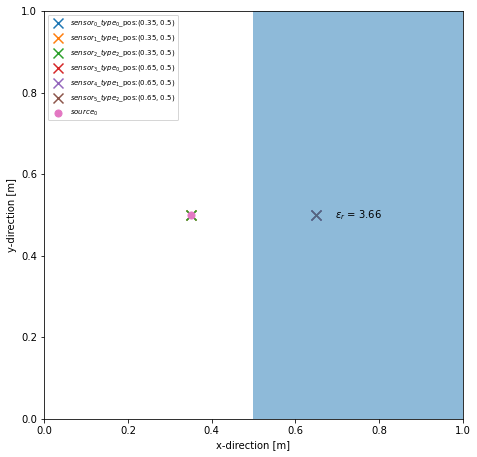

Space discretization steps should be between 0.001094 & 0.001641 [m]


In [49]:
# DEFINE MEASUREMENT BOX & SIMULATION PARAMETERS
Lx = 1 # in [m]
Ly = 1 # in [m]
Tmax = 5*10**(-9) # in [s]

# Include different dielectrics (free space is already added to simulation)
er1=3.66
er2=5
dielectric1 = dielectric(xmin=Lx/2  , xmax=Lx    , ymin=0   , ymax=Ly   , er=er1)
dielectric2 = dielectric(xmin=0.1   , xmax=0.5   , ymin=0   , ymax=0.6  , er=er2)

dielectrics = []
dielectrics.append(dielectric1)

# Distance of source (and measurement point in dielectric) from middle of measurement box
distance = 0.15

# Include sources
source1 = source(pos_x=Lx/2-distance, pos_y=Ly/2, J0=1, delay=4*10**(-10), pulse_width=1*10**(-10))

j_s = []
j_s.append(source1)

# Include sensors [type: 0 (E_z), 1 (H_x) or 2 (H_y)]
sensor0 = sensor(x=Lx/2-distance, y=Ly/2, type=0) # E_z sensor in free space on source
sensor1 = sensor(x=Lx/2-distance, y=Ly/2, type=1) # H_x sensor in free space on source
sensor2 = sensor(x=Lx/2-distance, y=Ly/2, type=2) # H_y sensor in free space on source
sensor3 = sensor(x=Lx/2+distance, y=Ly/2, type=0) # E_z sensor in dielectric
sensor4 = sensor(x=Lx/2+distance, y=Ly/2, type=1) # H_x sensor in dielectric
sensor5 = sensor(x=Lx/2+distance, y=Ly/2, type=2) # H_y sensor in dielectric

sen = []
sen.append(sensor0)
sen.append(sensor1)
sen.append(sensor2)
sen.append(sensor3)
sen.append(sensor4)
sen.append(sensor5)

# Visualize physical space (dielectric(s), source(s), sensor(s)
fig, ax = plt.subplots(figsize=(15*Lx/(Lx+Ly),15*Ly/(Lx+Ly)))
permittivity_list = []
for dielec in dielectrics:
    if dielec.er not in permittivity_list:
        permittivity_list.append(dielec.er)
    ax.add_patch(patches.Rectangle((dielec.xpos[0],dielec.ypos[0]),dielec.xpos[1]-dielec.xpos[0],dielec.ypos[1]-dielec.ypos[0], alpha=0.5,facecolor=f'C{permittivity_list.index(dielec.er)}'))
    ax.annotate(f'$\u03B5_r$ = {dielec.er}', ((dielec.xpos[1]+dielec.xpos[0])/2, (dielec.ypos[1]+dielec.ypos[0])/2), color='k', fontsize=10, ha='center', va='center')
er_max = np.max(permittivity_list)

for meetpunt in sen:
    tuple_pos = (meetpunt.pos[0],meetpunt.pos[1])
    ax.scatter(meetpunt.pos[0],meetpunt.pos[1], label=f"$sensor_{sen.index(meetpunt)}$_$type_{meetpunt.type}$_pos:{tuple_pos}",marker="x", s=100)

for bron in j_s:
    ax.scatter(bron.pos_x,bron.pos_y, label=f"$source_{j_s.index(bron)}$", s=50)

plt.legend(fontsize=7, loc="upper left")
plt.xlim([0,Lx])
plt.ylim([0,Ly])
plt.xlabel("x-direction [m]")
plt.ylabel("y-direction [m]")
plt.show()

lambda_min = j_s[0].lambda_min(er_max)
print("Space discretization steps should be between {min:.4g} & {max:.4g} [m]".format(min=lambda_min/30, max=lambda_min/20))

In [50]:
# INPUT SPACE DISCRETIZATION STEP BASED ON INFORMATION ABOVE
bounded_step = 1            # (0): free choice of grid discretization, (1): values should be between lambda_min/30 and lambda_min/20 [recommended]
dx = 0.001                  # cell size in x-direction in [m]
dy = 0.001                  # cell size in y-direction in [m]
# -----------------------------------------------------------
if bounded_step:
    if not lambda_min/30 <= dx <= lambda_min/20:
        dx = lambda_min/(20+10*Lx/(Lx+Ly))
    if not lambda_min/30 <= dy <= lambda_min/20:
        dy = lambda_min/(20+10*Ly/(Lx+Ly))
Nx = int(Lx/dx + 1)         # number of nodes in the x-direction
Ny = int(Ly/dy + 1)         # number of nodes in the y-direction

print(f"Number of space discretization steps in x direction: {Nx} and in the y-direction: {Ny}")

max_dt = 1 / (v * np.sqrt(1/(dx**2) + 1/(dy**2)))
print(f"Time discretization steps should be smaller than {max_dt} [s]")

Number of space discretization steps in x direction: 762 and in the y-direction: 762
Time discretization steps should be smaller than 3.0964428189442613e-12 [s]


In [51]:
# INPUT TIME DISCRETIZATION STEP BASED ON INFORMATION ABOVE
bounded_time = 1        # (0): free choice of time discretization, (1): force time step to be smaller than max_dt [recommended]
dt = 3e-12              # time step [s]
# ------------------------------------------
if bounded_time:
    if dt > max_dt:
        dt = max_dt
Nt = int(np.floor(Tmax/dt))  # number of time steps
print(f"Number of time steps: {Nt} (dt = {dt} s)")

# Discretization of physical space (all free space)
space = np.ones((Nx-1, Ny-1))

# Changing the permittivity of space on dielectric positions
for dielec in dielectrics:
    # Space step discretization
    i = int(dielec.xpos[0] / dx)
    j = int(dielec.ypos[0] / dy)
    x_length = int(dielec.xpos[1] / dx)
    y_length = int(dielec.ypos[1] / dy)
    space[i : i+ x_length, j : j+ y_length] = dielec.er
space = space[:-1, :-1] # translate the dielectrics slightly

interference_times = np.empty(len(sen))   

for i,meetpunt in enumerate(sen):
    # Initialize measurement sensor
    meetpunt.measurement(0)
    # Reflection on the PEC walls
    distance = np.empty((4,2))
    distance[0,:] = -meetpunt.pos[0],meetpunt.pos[1]
    distance[1,:] = meetpunt.pos[0],-meetpunt.pos[1]
    distance[2,:] = 2*Lx - meetpunt.pos[0], meetpunt.pos[1]
    distance[3,:] = meetpunt.pos[0],2*Ly- meetpunt.pos[1]
    distance -= (j_s[0].pos_x, j_s[0].pos_y)
    distance = np.linalg.norm(distance,axis=-1)
    min_distance = np.min(distance)
    interference_times[i] = min_distance/v

# Initialize fields space
ez = np.zeros((Nx,Ny))   # x-component magnetic field [V/m]
hx = np.zeros((Nx,Ny-1)) # y-component magnetic field [V/m]
hy = np.zeros((Nx-1,Ny)) # z-component electric field [V/m]

Number of time steps: 1666 (dt = 3e-12 s)


In [52]:
# Calculate the sensor positions in terms of steps
sensor_pos_x = np.asarray([meetpunt.pos[0] for meetpunt in sen])//dx
sensor_pos_y = np.asarray([meetpunt.pos[1] for meetpunt in sen])//dy
# Calculating the discretized postions of our line source (moet array worden in uitbreiding)
i_source = int(j_s[0].pos_x / dx)
j_source = int(j_s[0].pos_y / dy)

def visualize_field(field, title, title_x, title_y, filename=None):
    plt.figure(figsize = (15,8))
    plt.scatter(sensor_pos_x, sensor_pos_y, c="gray", label="sensors", marker="x")
    plt.scatter(j_s[0].pos_x//dx, j_s[0].pos_y//dy, c="red", label="source point", s=7)
    im = plt.imshow(np.transpose(field), origin='lower')
    plt.title(title)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    if filename is not None:
        #plt.imsave("./plots/" + filename + ".png", np.transpose(field)) #sneller
        fig = plt.gcf()
        fig.set_size_inches(15,8)
        fig.savefig("./plots/" + filename + ".png") #dit geeft wel mooiere figuur
    plt.close()

def update(iteration,visualize=False):
    # Update Hy
    hy[:,:] += dt/(mu0*dx)*(ez[1:,:]-ez[:-1,:])
    # Update Hx
    hx[:,:] -= dt/(mu0*dy)*(ez[:,1:]-ez[:,:-1])
    # Update E_z
    ez[1:-1,1:-1] += dt/(ep0*dx)*(hy[1:, 1:-1] - hy[:-1, 1:-1])/space
    ez[1:-1, 1:-1] -= dt / (ep0*dy) * (hx[1:-1, 1:] - hx[1:-1, :-1]) /space
    # Update source
    ez[i_source, j_source] -= j_s[0].current((iteration-1/2)*dt)*dt / (dx*dy*ep0*space[i_source, j_source])
       
    # Saving measurement for measurement points
    for meetpunt in sen:
        i, j = int(meetpunt.pos[0]/dx), int(meetpunt.pos[1]/dy)
        # int 0, 1 or 2 for e_z, h_x, and h_y
        if meetpunt.type == 0:
            E_z = ez[i, j] 
            meetpunt.measurement(E_z)
        elif meetpunt.type == 1:
            H_x = hx[i, j]
            meetpunt.measurement(H_x)
        elif meetpunt.type == 2:
            H_y = hy[i, j]
            meetpunt.measurement(H_y)
        else:
            print("Sensor type not known")
    if visualize == 1 or visualize == 3:
        visualize_field(field=abs(ez), title=f"$E_z$ t={iteration*dt} s", title_x = "i (x-axis)", title_y="j (y-axis)", filename=f"Ez/Ez-{iteration:06d}")      
    if visualize ==2 or visualize == 3:
        visualize_field(field=np.sqrt(hx[1:,]**2 + hy[:,1:]**2), title=f"H t={iteration*dt} s", title_x = "i (x-axis)", title_y="j (y-axis)", filename=f"H/H-{iteration:06d}")
        
    if iteration % (Nt//4) == 0 and iteration > 0:
        print("(Another) 1/4 done")

266 380


In [53]:
# INPUT WHETHER VISUALIZATION OF THE FIELDS IS PREFERRED (Note: takes quite a while (order of minutes depending on specifications) + saves alot of images in a folder)
visualize_fields = 0        # (0): no visualization [recommended], (1): visualize only E-field, (2): visualize only H-field, (3): visualize both E- and H-fields
add_stopcondition = 1       # (0): keep simulating Nt times, (1): stop simulating if reflections off PEC walls arrive on measurement points [recommended]
# -----------------------
import os
if visualize_fields == 1 or visualize_fields == 3:
    path = os.path.abspath(os.getcwd())
    if not os.path.isdir(f"{path}/plots/Ez"):
        os.mkdir("plots/Ez")
if visualize_fields == 2 or visualize_fields == 3:
    path = os.path.abspath(os.getcwd())
    if not os.path.isdir(f"{path}/plots/H"):
        os.mkdir("plots/H")

print(f"Iterating {Nt} times through the iterative algoritm to update the fields")
if add_stopcondition:
    stop_condition = np.min(interference_times)*1.5 # simulate tiny bit extra
for it in range(Nt):
    update(it,visualize=visualize_fields)
    if add_stopcondition:
        if it*dt > stop_condition:
            print(f"Stop condition reached after {it} iterations: reflections of PEC walls arrive")
            break

Iterating 1666 times through the iterative algoritm to update the fields
(Another) 1/4 done
(Another) 1/4 done
Stop condition reached after 1168 iterations: reflections of PEC walls arrive


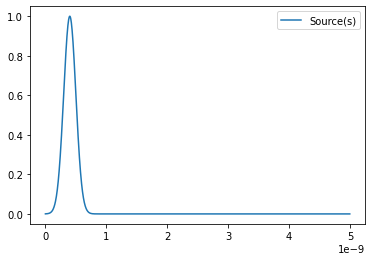

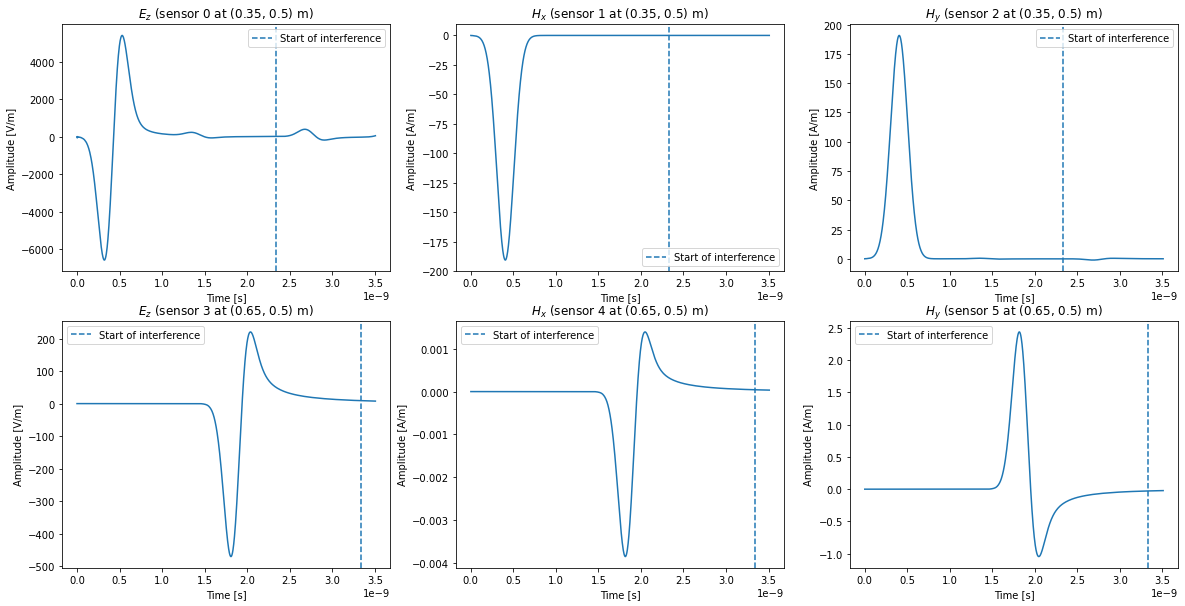

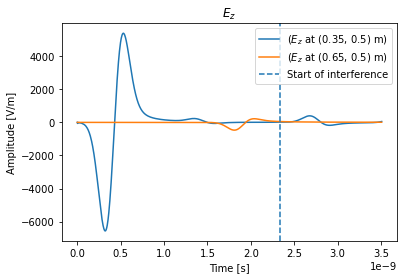

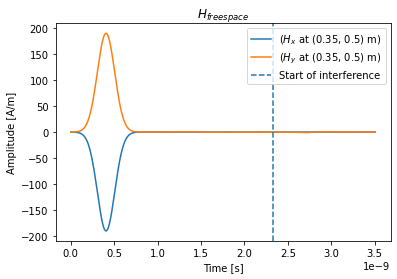

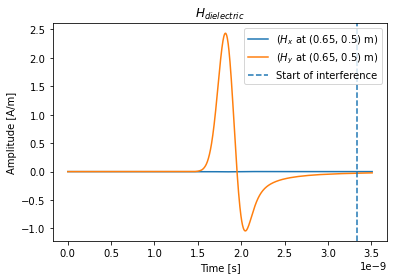

In [54]:
# Discrete time steps for H- and E-measurements
time_H = (np.arange(Nt+1) + 1/2) * dt
time_E = np.arange(Nt+1) * dt

sensor_type_count = np.zeros(3)
minmax = np.zeros(6)
for meetsensor in sen:
    sensor_type_count[meetsensor.type] = sensor_type_count[meetsensor.type] + 1
    min = np.min(meetsensor.measurements)
    max = np.max(meetsensor.measurements)
    if min < minmax[meetsensor.type]:
        minmax[meetsensor.type] = min
    elif max > minmax[meetsensor.type+3]:
        minmax[meetsensor.type+3] = max

plt.figure()
plt.plot(time_E,j_s[0].current(time_E), label="Source(s)")
plt.legend()
plt.show()

x = int(np.ceil(np.sqrt(len(sen))))
fig, axs = plt.subplots(int(np.max(sensor_type_count)), 3,figsize=(20,10)) #, sharey=True
for i in range(x):
    for j in range(x):
        if len(sen)<= j+x*i: #hack for np.ceil(np.sqrt...)
            continue
        if sen[j+x*i].type == 0:
            axs[i,0].plot(time_E[0:len(sen[j+x*i].measurements)], sen[j+x*i].measurements)
            axs[i,0].set_title(f"$E_z$ (sensor {j+x*i} at {sen[j+x*i].pos} m)")
            axs[i,0].axvline(interference_times[j+x*i], linestyle='--', label="Start of interference")
            axs[i,0].legend()
            axs[i,0].set_xlabel("Time [s]")
            axs[i,0].set_ylabel("Amplitude [V/m]")
            # axs[i,0].set_ylim(minmax[0],minmax[3])
        elif sen[j+x*i].type == 1:
            axs[i,1].set_title(f"$H_x$ (sensor {j+x*i} at {sen[j+x*i].pos} m)")
            axs[i,1].plot(time_H[0:len(sen[j+x*i].measurements)], sen[j+x*i].measurements)
            axs[i,1].axvline(interference_times[j+x*i], linestyle='--', label="Start of interference")
            axs[i,1].legend()
            axs[i,1].set_xlabel("Time [s]")
            axs[i,1].set_ylabel("Amplitude [A/m]")
            # axs[i,1].set_ylim(minmax[1],minmax[4])
        elif sen[j+x*i].type == 2:
            axs[i,2].set_title(f"$H_y$ (sensor {j+x*i} at {sen[j+x*i].pos} m)")
            axs[i,2].plot(time_H[0:len(sen[j+x*i].measurements)], sen[j+x*i].measurements)
            axs[i,2].axvline(interference_times[j+x*i], linestyle='--', label="Start of interference")
            axs[i,2].legend()
            axs[i,2].set_xlabel("Time [s]")
            axs[i,2].set_ylabel("Amplitude [A/m]")
            # axs[i,2].set_ylim(minmax[2],minmax[5])
plt.show()

plt.plot(time_E[0:len(sen[0].measurements)], sen[0].measurements, label= f"($E_z$ at {sen[0].pos} m)")
plt.plot(time_E[0:len(sen[3].measurements)], sen[3].measurements, label= f"($E_z$ at {sen[3].pos} m)")
plt.title(f"$E_z$")
plt.axvline(interference_times[0], linestyle='--', label="Start of interference")
plt.legend(loc='upper right')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V/m]")
# plt.ylim(-1000,1000)
plt.show()

plt.plot(time_H[0:len(sen[1].measurements)], sen[1].measurements, label= f"($H_x$ at {sen[1].pos} m)")
plt.plot(time_H[0:len(sen[2].measurements)], sen[2].measurements, label= f"($H_y$ at {sen[2].pos} m)")
plt.title("$H_{freespace}$")
plt.axvline(interference_times[1], linestyle='--', label="Start of interference")
plt.legend(loc='upper right')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [A/m]")
# plt.ylim(-1,1)
plt.show()

plt.plot(time_H[0:len(sen[4].measurements)], sen[4].measurements, label= f"($H_x$ at {sen[4].pos} m)")
plt.plot(time_H[0:len(sen[5].measurements)], sen[5].measurements, label= f"($H_y$ at {sen[5].pos} m)")
plt.title("$H_{dielectric}$")
plt.axvline(interference_times[4], linestyle='--', label="Start of interference")
plt.legend(loc='upper right')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [A/m]")
# plt.ylim(-0.1,0.1)
plt.show()

In [ ]:
# Convert saved pictures of the first sensor's fields in a video
if visualize_fields == 1 or visualize_fields == 3:
    import cv2
    image_folder = f"plots/Ez"
    video_name = 'FDTD_video_Ez-field.avi'
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), fps=60,frameSize=(width, height))
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()

if visualize_fields == 2 or visualize_fields == 3:
    import cv2
    image_folder = f"plots/H"
    video_name = 'FDTD_video_H-field.avi'
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), fps=60,frameSize=(width, height))
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()